In [1]:
# Define the base directories for train and validation
train_base_path = r"C:\Users\athar\Downloads\EC_ATML_Project\vggface2_trimmed"
val_base_path   = r"C:\Users\athar\Downloads\EC_ATML_Project\vggface2_val_trimmed"


In [2]:
import os
import random
import pandas as pd

def generate_pairs(base_path, num_same=5000, num_diff=5000):
    people = os.listdir(base_path)
    people = [p for p in people if os.path.isdir(os.path.join(base_path, p))]
    data = []

    # Generate same-person pairs
    for _ in range(num_same):
        person = random.choice(people)
        imgs = os.listdir(os.path.join(base_path, person))
        if len(imgs) < 2:
            continue
        img1, img2 = random.sample(imgs, 2)
        data.append([f"{person}/{img1}", f"{person}/{img2}", 1])

    # Generate different-person pairs
    for _ in range(num_diff):
        p1, p2 = random.sample(people, 2)
        img1 = random.choice(os.listdir(os.path.join(base_path, p1)))
        img2 = random.choice(os.listdir(os.path.join(base_path, p2)))
        data.append([f"{p1}/{img1}", f"{p2}/{img2}", 0])

    df = pd.DataFrame(data, columns=['img1', 'img2', 'label'])
    return df

# Generate and save the pairs
df_train = generate_pairs(train_base_path, num_same=5000, num_diff=5000)
df_val = generate_pairs(val_base_path, num_same=1000, num_diff=1000)

df_train.to_csv("train_pairs.csv", index=False)
df_val.to_csv("val_pairs.csv", index=False)


In [3]:
# Load the generated CSVs
df_train = pd.read_csv("train_pairs.csv")
df_val = pd.read_csv("val_pairs.csv")


In [4]:
df_train

,img1,img2,label
0,n000352/0023_02.jpg,n000352/0018_02.jpg,1
1,n000418/0114_01.jpg,n000418/0169_01.jpg,1
2,n000053/0090_01.jpg,n000053/0017_01.jpg,1
3,n000332/0358_01.jpg,n000332/0319_01.jpg,1
4,n000499/0084_01.jpg,n000499/0163_01.jpg,1
...,...,...,...
9995,n000466/0069_01.jpg,n000127/0187_01.jpg,0
9996,n000371/0017_01.jpg,n000025/0018_01.jpg,0
9997,n000099/0137_01.jpg,n000446/0165_01.jpg,0
9998,n000465/0245_02.jpg,n000198/0117_01.jpg,0


In [5]:
df_val

,img1,img2,label
0,n000945/0376_01.jpg,n000945/0141_01.jpg,1
1,n000284/0089_02.jpg,n000284/0105_03.jpg,1
2,n001296/0019_01.jpg,n001296/0137_01.jpg,1
3,n000746/0243_01.jpg,n000746/0225_01.jpg,1
4,n001242/0155_01.jpg,n001242/0127_01.jpg,1
...,...,...,...
1995,n000785/0214_05.jpg,n000148/0362_01.jpg,0
1996,n000029/0317_07.jpg,n001199/0052_01.jpg,0
1997,n001291/0132_01.jpg,n000912/0225_01.jpg,0
1998,n000945/0167_01.jpg,n000149/0055_02.jpg,0


In [3]:
# Importing Libararies
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from pyswarm import pso

from scipy.spatial.distance import euclidean


In [ ]:
# setting up the directories 

train_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\vggface2_trimmed"
val_dir   = r"C:\Users\athar\Downloads\EC_ATML_Project\vggface2_val_trimmed"


In [ ]:
# Dataset Processing – Few-Shot Pair Dataset for training/validation
# This dataset creates pairs (50% positive, 50% negative)

class FewShotPairs(Dataset):
    def __init__(self, root_dir, transform=None, n_way=5, k_shot=5):
        self.root_dir = root_dir
        self.transform = transform
        self.n_way = n_way
        self.k_shot = k_shot
        self.class_folders = [os.path.join(root_dir, cls) for cls in os.listdir(root_dir)]
        self.class_folders = [f for f in self.class_folders if os.path.isdir(f)]

    def __len__(self):
        return 10000  

    def __getitem__(self, idx):
        
        
        if random.random() < 0.5:
        
           
            cls_path = random.choice(self.class_folders)
            images = os.listdir(cls_path)
            if len(images) < 2:
                return self.__getitem__(idx)
            img1_name, img2_name = random.sample(images, 2)
            label = 1.0
        
            
            cls1 = cls_path
            cls2 = cls_path
        else:
        
           
            cls1, cls2 = random.sample(self.class_folders, 2)
            img1_name = random.choice(os.listdir(cls1))
            img2_name = random.choice(os.listdir(cls2))
            label = 0.0

        img1 = Image.open(os.path.join(cls1, img1_name)).convert("RGB")
        img2 = Image.open(os.path.join(cls2, img2_name)).convert("RGB")
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [107]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# PSO Optimization for Data Augmentation Tuning

# Defining a temporary Siamese model to be used only for augmentation tuning.

class ResNetSiamese(nn.Module):
    def __init__(self):
        super(ResNetSiamese, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(), nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward_one(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)

    def forward(self, x1, x2):
        f1 = self.forward_one(x1)
        f2 = self.forward_one(x2)
        diff = torch.abs(f1 - f2)
        return self.fc(diff)
    
# Create a temporary instance of the Siamese model for tuning purposes.
temp_model = ResNetSiamese().to(device)
temp_model.eval()

def tune_augment(params):
    rot, bright, contrast = params
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(int(rot)),
        transforms.ColorJitter(brightness=bright, contrast=contrast),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
  
    temp_dataset = FewShotPairs(train_dir, transform=transform)
    loader = DataLoader(temp_dataset, batch_size=32, shuffle=True)
    
    with torch.no_grad():
        acc_total = 0
       
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
            out = temp_model(x1, x2)  # Calling our Siamese model
            pred = (torch.sigmoid(out) > 0.5).float()
            acc_total += (pred == y).sum().item() / y.size(0)
            break  

    return 1 - (acc_total / 1)


best_aug_params, _ = pso(
    tune_augment,
    lb=[5, 0.1, 0.1], ub=[30, 1.0, 1.0],
    swarmsize=8, maxiter=8
)
print(f"Best augmentation params (rotation, brightness, contrast): {best_aug_params}")


best_rot, best_bright, best_contrast = best_aug_params
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(int(best_rot)),
    transforms.ColorJitter(brightness=best_bright, contrast=best_contrast),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


Stopping search: maximum iterations reached --> 8
Best augmentation params (rotation, brightness, contrast): [5.11069683 0.5351424  0.96725469]


In [ ]:
#  DataLoaders (Re-create datasets using the tuned transforms)
train_dataset = FewShotPairs(train_dir, transform=train_transform)
val_dataset = FewShotPairs(val_dir, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Defining the Siamese Network (ResNet18 Based)
class ResNetSiamese(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(), nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward_one(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)

    def forward(self, x1, x2):
        f1, f2 = self.forward_one(x1), self.forward_one(x2)
        dist = torch.abs(f1 - f2)
        return self.fc(dist)

model = ResNetSiamese().to(device)


In [ ]:
# Training and Evaluation Functions
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for x1, x2, y in loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        out = model(x1, x2)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        preds = (torch.sigmoid(out) > 0.5).float()
        correct += (preds == y).sum().item()
        total += y.size(0)
        loss_sum += loss.item() * y.size(0)
    return loss_sum / total, correct / total

def evaluate_model(model, loader, criterion, device, threshold=0.5):
    model.eval()
    total, correct, loss_sum = 0, 0, 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for x1, x2, y in loader:
            x1, x2, y = x1.to(device), x2.to(device), y.to(device).unsqueeze(1)
            out = model(x1, x2)
            loss = criterion(out, y)
            prob = torch.sigmoid(out)
            pred = (prob > threshold).float()
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_probs.extend(prob.cpu().numpy())
            correct += (pred == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item() * y.size(0)
    return loss_sum / total, correct / total, np.array(all_labels), np.array(all_preds), np.array(all_probs)




In [124]:
import time
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss, optimizer, and scheduler
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 45

# Lists to record epoch-wise metrics and elapsed time
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_times = []

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training loop with per-batch progress bar
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    train_batches = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    
    for images1, images2, labels in train_batches:
        images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images1, images2)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        batch_size = labels.size(0)
        total_train_loss += loss.item() * batch_size
        preds = (torch.sigmoid(outputs) > 0.5).float()
        total_train_correct += (preds == labels.unsqueeze(1)).sum().item()
        total_train_samples += batch_size
        
        # Update inner progress bar with current batch loss
        train_batches.set_postfix(loss=f"{loss.item():.4f}")
    
    epoch_train_loss = total_train_loss / total_train_samples
    epoch_train_acc = total_train_correct / total_train_samples

    # Validation loop with per-batch progress bar
    model.eval()
    total_val_loss = 0.0
    total_val_correct = 0
    total_val_samples = 0
    val_batches = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
    
    with torch.no_grad():
        for images1, images2, labels in val_batches:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
            outputs = model(images1, images2)
            loss = criterion(outputs, labels.unsqueeze(1))
            batch_size = labels.size(0)
            total_val_loss += loss.item() * batch_size
            preds = (torch.sigmoid(outputs) > 0.5).float()
            total_val_correct += (preds == labels.unsqueeze(1)).sum().item()
            total_val_samples += batch_size
            
            # Update inner progress bar with current batch loss
            val_batches.set_postfix(loss=f"{loss.item():.4f}")
    
    epoch_val_loss = total_val_loss / total_val_samples
    epoch_val_acc = total_val_correct / total_val_samples

    # Step the scheduler based on validation loss
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    elapsed = time.time() - start_time

    # Record epoch metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    epoch_times.append(elapsed)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    print(f"  Val Loss:   {epoch_val_loss:.4f}, Val Acc:   {epoch_val_acc:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Elapsed Time: {elapsed:.2f} seconds")


Epoch 1/45 - Training:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 1/45:
  Train Loss: 0.5956, Train Acc: 0.6758
  Val Loss:   0.5594, Val Acc:   0.7016
  Learning Rate: 0.000100
  Elapsed Time: 154.69 seconds



Epoch 2/45:
  Train Loss: 0.5657, Train Acc: 0.7048
  Val Loss:   0.5571, Val Acc:   0.7014
  Learning Rate: 0.000100
  Elapsed Time: 144.58 seconds



Epoch 3/45:
  Train Loss: 0.5545, Train Acc: 0.7131
  Val Loss:   0.5343, Val Acc:   0.7229
  Learning Rate: 0.000100
  Elapsed Time: 146.97 seconds



Epoch 4/45:
  Train Loss: 0.5342, Train Acc: 0.7325
  Val Loss:   0.5376, Val Acc:   0.7228
  Learning Rate: 0.000100
  Elapsed Time: 144.92 seconds



Epoch 5/45:
  Train Loss: 0.5277, Train Acc: 0.7326
  Val Loss:   0.5080, Val Acc:   0.7461
  Learning Rate: 0.000100
  Elapsed Time: 143.70 seconds



Epoch 6/45:
  Train Loss: 0.5061, Train Acc: 0.7535
  Val Loss:   0.5039, Val Acc:   0.7542
  Learning Rate: 0.000100
  Elapsed Time: 143.26 seconds



Epoch 7/45:
  Train Loss: 0.4959, Train Acc: 0.7602
  Val Loss:   0.4923, Val Acc:   0.7618
  Learning Rate: 0.000100
  Elapsed Time: 142.31 seconds



Epoch 8/45:
  Train Loss: 0.4759, Train Acc: 0.7726
  Val Loss:   0.4834, Val Acc:   0.7636
  Learning Rate: 0.000100
  Elapsed Time: 142.48 seconds



Epoch 9/45:
  Train Loss: 0.4782, Train Acc: 0.7699
  Val Loss:   0.4780, Val Acc:   0.7651
  Learning Rate: 0.000100
  Elapsed Time: 141.61 seconds



Epoch 10/45:
  Train Loss: 0.4661, Train Acc: 0.7775
  Val Loss:   0.4687, Val Acc:   0.7777
  Learning Rate: 0.000100
  Elapsed Time: 141.53 seconds



Epoch 11/45:
  Train Loss: 0.4557, Train Acc: 0.7883
  Val Loss:   0.4673, Val Acc:   0.7789
  Learning Rate: 0.000100
  Elapsed Time: 140.66 seconds



Epoch 12/45:
  Train Loss: 0.4523, Train Acc: 0.7847
  Val Loss:   0.4657, Val Acc:   0.7803
  Learning Rate: 0.000100
  Elapsed Time: 141.30 seconds



Epoch 13/45:
  Train Loss: 0.4454, Train Acc: 0.7940
  Val Loss:   0.4435, Val Acc:   0.7964
  Learning Rate: 0.000100
  Elapsed Time: 143.18 seconds



Epoch 14/45:
  Train Loss: 0.4390, Train Acc: 0.7946
  Val Loss:   0.4590, Val Acc:   0.7868
  Learning Rate: 0.000100
  Elapsed Time: 142.08 seconds



Epoch 15/45:
  Train Loss: 0.4432, Train Acc: 0.7879
  Val Loss:   0.4419, Val Acc:   0.7949
  Learning Rate: 0.000100
  Elapsed Time: 141.33 seconds



Epoch 16/45:
  Train Loss: 0.4412, Train Acc: 0.7890
  Val Loss:   0.4471, Val Acc:   0.7859
  Learning Rate: 0.000100
  Elapsed Time: 140.38 seconds



Epoch 17/45:
  Train Loss: 0.4282, Train Acc: 0.7994
  Val Loss:   0.4504, Val Acc:   0.7890
  Learning Rate: 0.000100
  Elapsed Time: 141.49 seconds



Epoch 18/45:
  Train Loss: 0.4165, Train Acc: 0.8075
  Val Loss:   0.4551, Val Acc:   0.7859
  Learning Rate: 0.000100
  Elapsed Time: 140.67 seconds



Epoch 19/45:
  Train Loss: 0.4177, Train Acc: 0.8091
  Val Loss:   0.4544, Val Acc:   0.7894
  Learning Rate: 0.000050
  Elapsed Time: 140.73 seconds



Epoch 20/45:
  Train Loss: 0.4046, Train Acc: 0.8177
  Val Loss:   0.4226, Val Acc:   0.8083
  Learning Rate: 0.000050
  Elapsed Time: 140.70 seconds



Epoch 21/45:
  Train Loss: 0.3907, Train Acc: 0.8261
  Val Loss:   0.4044, Val Acc:   0.8178
  Learning Rate: 0.000050
  Elapsed Time: 140.30 seconds



Epoch 22/45:
  Train Loss: 0.3960, Train Acc: 0.8172
  Val Loss:   0.4025, Val Acc:   0.8205
  Learning Rate: 0.000050
  Elapsed Time: 140.34 seconds



Epoch 23/45:
  Train Loss: 0.3849, Train Acc: 0.8278
  Val Loss:   0.4127, Val Acc:   0.8120
  Learning Rate: 0.000050
  Elapsed Time: 140.62 seconds



Epoch 24/45:
  Train Loss: 0.3732, Train Acc: 0.8367
  Val Loss:   0.4087, Val Acc:   0.8165
  Learning Rate: 0.000050
  Elapsed Time: 139.94 seconds



Epoch 25/45:
  Train Loss: 0.3804, Train Acc: 0.8312
  Val Loss:   0.3964, Val Acc:   0.8232
  Learning Rate: 0.000050
  Elapsed Time: 140.08 seconds



Epoch 26/45:
  Train Loss: 0.3743, Train Acc: 0.8333
  Val Loss:   0.4012, Val Acc:   0.8174
  Learning Rate: 0.000050
  Elapsed Time: 140.12 seconds



Epoch 27/45:
  Train Loss: 0.3615, Train Acc: 0.8420
  Val Loss:   0.3901, Val Acc:   0.8238
  Learning Rate: 0.000050
  Elapsed Time: 141.83 seconds



Epoch 28/45:
  Train Loss: 0.3623, Train Acc: 0.8402
  Val Loss:   0.4047, Val Acc:   0.8217
  Learning Rate: 0.000050
  Elapsed Time: 147.93 seconds



Epoch 29/45:
  Train Loss: 0.3559, Train Acc: 0.8435
  Val Loss:   0.3962, Val Acc:   0.8193
  Learning Rate: 0.000050
  Elapsed Time: 145.42 seconds



Epoch 30/45:
  Train Loss: 0.3611, Train Acc: 0.8406
  Val Loss:   0.3864, Val Acc:   0.8288
  Learning Rate: 0.000050
  Elapsed Time: 144.47 seconds



Epoch 31/45:
  Train Loss: 0.3668, Train Acc: 0.8346
  Val Loss:   0.4097, Val Acc:   0.8170
  Learning Rate: 0.000050
  Elapsed Time: 143.12 seconds



Epoch 32/45:
  Train Loss: 0.3477, Train Acc: 0.8465
  Val Loss:   0.3930, Val Acc:   0.8233
  Learning Rate: 0.000050
  Elapsed Time: 142.35 seconds



Epoch 33/45:
  Train Loss: 0.3502, Train Acc: 0.8426
  Val Loss:   0.3844, Val Acc:   0.8274
  Learning Rate: 0.000050
  Elapsed Time: 142.32 seconds



Epoch 34/45:
  Train Loss: 0.3525, Train Acc: 0.8463
  Val Loss:   0.3854, Val Acc:   0.8245
  Learning Rate: 0.000050
  Elapsed Time: 142.38 seconds



Epoch 35/45:
  Train Loss: 0.3533, Train Acc: 0.8391
  Val Loss:   0.3833, Val Acc:   0.8309
  Learning Rate: 0.000050
  Elapsed Time: 141.24 seconds



Epoch 36/45:
  Train Loss: 0.3396, Train Acc: 0.8542
  Val Loss:   0.3953, Val Acc:   0.8235
  Learning Rate: 0.000050
  Elapsed Time: 141.83 seconds



Epoch 37/45:
  Train Loss: 0.3492, Train Acc: 0.8444
  Val Loss:   0.4003, Val Acc:   0.8209
  Learning Rate: 0.000050
  Elapsed Time: 141.25 seconds



Epoch 38/45:
  Train Loss: 0.3450, Train Acc: 0.8461
  Val Loss:   0.3742, Val Acc:   0.8336
  Learning Rate: 0.000050
  Elapsed Time: 141.01 seconds



Epoch 39/45:
  Train Loss: 0.3434, Train Acc: 0.8492
  Val Loss:   0.3702, Val Acc:   0.8374
  Learning Rate: 0.000050
  Elapsed Time: 141.13 seconds



Epoch 40/45:
  Train Loss: 0.3275, Train Acc: 0.8579
  Val Loss:   0.3649, Val Acc:   0.8351
  Learning Rate: 0.000050
  Elapsed Time: 140.67 seconds



Epoch 41/45:
  Train Loss: 0.3397, Train Acc: 0.8517
  Val Loss:   0.3746, Val Acc:   0.8380
  Learning Rate: 0.000050
  Elapsed Time: 140.74 seconds



Epoch 42/45:
  Train Loss: 0.3259, Train Acc: 0.8582
  Val Loss:   0.3709, Val Acc:   0.8350
  Learning Rate: 0.000050
  Elapsed Time: 148.72 seconds



Epoch 43/45:
  Train Loss: 0.3384, Train Acc: 0.8515
  Val Loss:   0.3704, Val Acc:   0.8360
  Learning Rate: 0.000050
  Elapsed Time: 178.52 seconds



Epoch 44/45:
  Train Loss: 0.3302, Train Acc: 0.8544
  Val Loss:   0.3676, Val Acc:   0.8366
  Learning Rate: 0.000025
  Elapsed Time: 141.26 seconds



Epoch 45/45:
  Train Loss: 0.3171, Train Acc: 0.8613
  Val Loss:   0.3681, Val Acc:   0.8411
  Learning Rate: 0.000025
  Elapsed Time: 142.42 seconds


In [ ]:
# PSO for Threshold Optimization (Using a Subset of the Validation Set to Speed Up)


subset_size = min(200, len(val_dataset))
val_subset_indices = np.random.choice(len(val_dataset), size=subset_size, replace=False)
val_subset = torch.utils.data.Subset(val_dataset, val_subset_indices)
subset_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

def threshold_objective(threshold, model, loader, device):
    # threshold is provided as a list [value]
    _, acc, _, _, _ = evaluate_model(model, loader, criterion, device, threshold=threshold[0])
    return 1 - acc  # We want to maximize accuracy, so minimize (1 - accuracy)

# Optionally reduce swarmsize and maxiter for faster convergence.
opt_threshold, _ = pso(
    func=lambda th: threshold_objective(th, model, subset_loader, device),
    lb=[0.1], ub=[1.5],
    swarmsize=5, maxiter=5  # Reduced for speed
)
optimal_threshold = opt_threshold[0]
print(f"Optimal verification threshold from PSO: {optimal_threshold:.4f}")


Stopping search: maximum iterations reached --> 5
Optimal verification threshold from PSO: 0.2101


Classification Report:
              precision    recall  f1-score   support

   Different       0.84      0.84      0.84      5029
        Same       0.84      0.84      0.84      4971

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

ROC-AUC Score: 0.9131


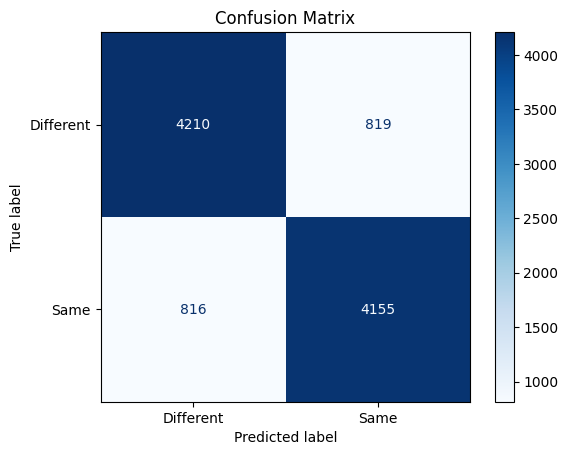

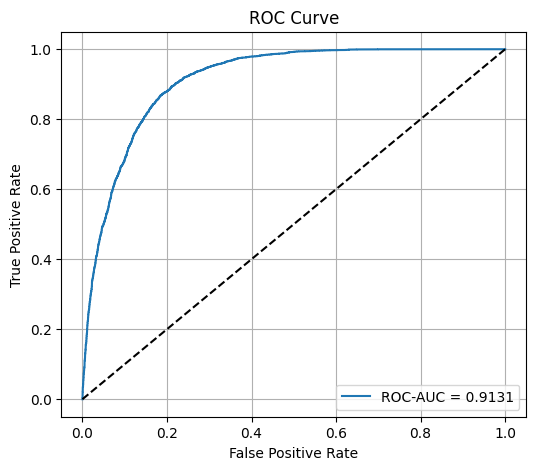

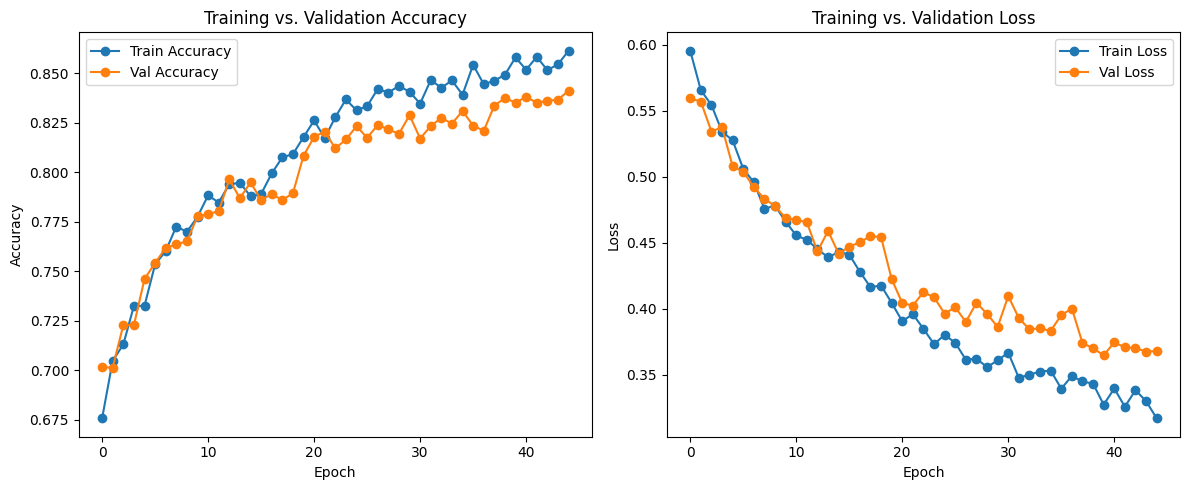

In [ ]:
# Evaluation Metrics & Graphs

optimal_threshold = 0.60
val_loss, val_acc, all_labels, all_preds, all_probs = evaluate_model(model, val_loader, criterion, device, threshold=optimal_threshold)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Different", "Same"]))

roc_auc = roc_auc_score(all_labels, all_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy/Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, marker='o', label='Train Accuracy')
plt.plot(val_accuracies, marker='o', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import torch
from PIL import Image
from torchvision import transforms


class ResNetSiamese(nn.Module):
    def __init__(self,backbone):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(), nn.Dropout(0.7),
            nn.Linear(512, 256),
            nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(256, 128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward_one(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)

    def forward(self, x1, x2):
        f1, f2 = self.forward_one(x1), self.forward_one(x2)
        dist = torch.abs(f1 - f2)
        return self.fc(dist)


def load_model(pth_path, device):
    from torchvision.models import resnet18
    backbone = resnet18(pretrained=False)
    backbone.fc = torch.nn.Identity()
    
    model = ResNetSiamese(backbone)
    model.load_state_dict(torch.load(pth_path, map_location=device))
    model.to(device)
    return model


def evaluate_image_pair(model, image_path1, image_path2, eval_transform, device, optimal_threshold=0.5):
    image1 = Image.open(image_path1).convert("RGB")
    image2 = Image.open(image_path2).convert("RGB")

    img1_tensor = eval_transform(image1).unsqueeze(0).to(device)
    img2_tensor = eval_transform(image2).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img1_tensor, img2_tensor)
        probability = torch.sigmoid(output).item()

    prediction = "Same Identity" if probability > optimal_threshold else "Different Identities"
    
    print(f"Prediction probability (same identity): {probability:.4f}")
    print(f"Model predicts: {prediction}")
    
    return probability, prediction


if __name__ == "__main__":
    pth_file = "Siamese_VGG_83.pth" 
    image_path1 = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images\obama\download (5).jpeg"
    image_path2 = r"obama_query.png"
    optimal_threshold = 0.5  

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    model = load_model(pth_file, device)
    evaluate_image_pair(model, image_path1, image_path2, eval_transform, device, optimal_threshold)


C:\Users\athar\AppData\Local\Temp\ipykernel_11128\716255409.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_path, map_location=devi

Prediction probability (same identity): 0.9754
Model predicts: Same Identity


In [136]:
torch.save(model.state_dict(), 'Siamese_VGG_83.pth')

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import os
from PIL import Image
import numpy as np
from torchvision import models


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetSiamese().to(device)
model.load_state_dict(torch.load(r"C:\Users\athar\Downloads\EC_ATML_Project\Siamese_VGG_83.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def get_embedding(image_path):
    image = default_loader(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.forward_one(image)
    return embedding.squeeze(0)


def weighted_average(distances, epsilon=1e-6):
    d_max = max(distances)
    weights = [(d_max - d + epsilon) for d in distances]
    weighted_avg = sum(w * d for w, d in zip(weights, distances)) / sum(weights)
    return weighted_avg


def predict_identity(query_img_path, support_dir, threshold=0.5):
    
    query_embedding = get_embedding(query_img_path)
    results = {}
    
    for person in os.listdir(support_dir):
        person_dir = os.path.join(support_dir, person)
        if not os.path.isdir(person_dir):
            continue

        distances = []
        for img_file in os.listdir(person_dir):
            img_path = os.path.join(person_dir, img_file)
            support_embedding = get_embedding(img_path)

            # Compute Euclidean distance between query and support embedding:
            distance = torch.norm(query_embedding - support_embedding, p=2).item()
            distances.append(distance)

        # Compute weighted average using our custom function:
        weighted_avg = weighted_average(distances)
        results[person] = {
            "weighted_avg": weighted_avg,
            "all": [round(d, 4) for d in distances]
        }

  
    print("--- Distances from Query to Each User ---")
    for person, dist_info in results.items():
        print(f"User '{person}': Weighted Avg Distance = {dist_info['weighted_avg']:.4f}, All Distances = {dist_info['all']}")
    
    # Find the user with the lowest weighted average
    best_match = min(results.items(), key=lambda x: x[1]["weighted_avg"])
    best_user = best_match[0]
    best_score = best_match[1]["weighted_avg"]

    # Check the threshold
    if best_score <= threshold:
        print(f"\nBest Match: {best_user} (Weighted Avg Distance = {best_score:.4f})")
        print(f"Face recognized as '{best_user}'")
        return best_user, best_score
    else:
        print(f"\nBest Match: {best_user} (Weighted Avg Distance = {best_score:.4f})")
        print(" Face NOT recognized (no match found).")
        return None, best_score

support_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images"
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\tanish_query.jpeg"

predict_identity(query_img_path, support_dir, threshold=6)


C:\Users\athar\AppData\Local\Temp\ipykernel_12588\1750509415.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\athar\Downloads

--- Distances from Query to Each User ---
User 'modi': Weighted Avg Distance = 9.3232, All Distances = [8.9161, 12.973, 10.2031, 9.1122, 12.9804]
User 'obama': Weighted Avg Distance = 11.9307, All Distances = [15.9178, 10.2989, 12.456, 13.8924, 13.1513]
User 'trump': Weighted Avg Distance = 9.5828, All Distances = [8.9904, 13.3157, 13.6801, 9.7367, 9.7916]

Best Match: modi (Weighted Avg Distance = 9.3232)
 Face NOT recognized (no match found).


(None, 9.323196548963494)

In [155]:
support_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images"
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\obama_query.png"

predict_identity(query_img_path, support_dir, threshold=6)

--- Distances from Query to Each User ---
User 'modi': Weighted Avg Distance = 6.8955, All Distances = [6.1622, 9.2267, 9.971, 6.5274, 8.6297]
User 'obama': Weighted Avg Distance = 5.4094, All Distances = [8.5855, 4.0517, 6.3004, 6.0826, 6.7027]
User 'trump': Weighted Avg Distance = 5.7828, All Distances = [4.7623, 9.2642, 9.2756, 6.7611, 6.5575]

Best Match: obama (Weighted Avg Distance = 5.4094)
Face recognized as 'obama'


('obama', 5.4094424301761075)

In [156]:
support_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images"
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\modi_query.jpeg"

predict_identity(query_img_path, support_dir, threshold=6)

--- Distances from Query to Each User ---
User 'modi': Weighted Avg Distance = 5.3607, All Distances = [7.1267, 5.868, 8.9347, 6.4949, 3.8753]
User 'obama': Weighted Avg Distance = 6.5631, All Distances = [8.2867, 6.4664, 6.6553, 8.8599, 6.2021]
User 'trump': Weighted Avg Distance = 5.6072, All Distances = [5.7834, 6.2049, 6.6107, 5.6657, 5.2751]

Best Match: modi (Weighted Avg Distance = 5.3607)
Face recognized as 'modi'


('modi', 5.360730371639931)

In [157]:
support_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images"
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\trump_query.jpeg"

predict_identity(query_img_path, support_dir, threshold=6)

--- Distances from Query to Each User ---
User 'modi': Weighted Avg Distance = 9.2886, All Distances = [10.6278, 9.7263, 11.4485, 10.4882, 8.3262]
User 'obama': Weighted Avg Distance = 8.0007, All Distances = [7.8026, 8.3081, 8.4262, 9.3927, 7.7405]
User 'trump': Weighted Avg Distance = 3.8051, All Distances = [8.2336, 3.2614, 3.3963, 8.6142, 7.7663]

Best Match: trump (Weighted Avg Distance = 3.8051)
Face recognized as 'trump'


('trump', 3.80512994893268)

In [158]:
support_dir = r"C:\Users\athar\Downloads\EC_ATML_Project\few_shot_images"
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\KSI.jpeg"

predict_identity(query_img_path, support_dir, threshold=6)

--- Distances from Query to Each User ---
User 'modi': Weighted Avg Distance = 6.1485, All Distances = [5.1215, 9.0206, 10.5263, 5.5203, 8.9859]
User 'obama': Weighted Avg Distance = 8.9114, All Distances = [12.5588, 7.817, 8.8708, 10.4683, 9.621]
User 'trump': Weighted Avg Distance = 7.8005, All Distances = [8.3235, 12.3623, 12.4461, 7.0945, 8.0848]

Best Match: modi (Weighted Avg Distance = 6.1485)
 Face NOT recognized (no match found).


(None, 6.148522191257605)

In [163]:
query_img_path = r"C:\Users\athar\Downloads\EC_ATML_Project\speed_query.jpeg"

predict_identity(query_img_path, support_dir, threshold=6)

--- Distances from Query to Each User ---
User 'KSI': Weighted Avg Distance = 6.4825, All Distances = [8.2054, 6.1317, 7.2232]
User 'modi': Weighted Avg Distance = 7.0402, All Distances = [6.8373, 10.9529, 10.8377, 6.9168, 10.7086]
User 'obama': Weighted Avg Distance = 10.1574, All Distances = [13.8905, 8.7294, 10.539, 11.5237, 11.2321]
User 'Speed': Weighted Avg Distance = 5.2569, All Distances = [5.2569]
User 'trump': Weighted Avg Distance = 9.2957, All Distances = [9.0357, 13.5262, 13.7671, 8.9865, 9.7124]

Best Match: Speed (Weighted Avg Distance = 5.2569)
Face recognized as 'Speed'


('Speed', 5.256915092468262)